In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F



writer = SummaryWriter('runs/Bhahdanau_attention_LSTM')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Device name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Using device: cuda
Device name: NVIDIA GeForce GTX 1650


In [63]:
data = pd.read_csv("data/Dataset_English_Hindi.csv")
data.sample(5)

,English,Hindi
41435,A life-time of disciplined living and delibera...,भावनाओं के इस समुद्र पर अनुशासन की जिंदगी और द...
15784,Some young people did n't realise that sniffin...,कुछ युवा लोगों के दिमाग में यह बात नहीं आती है...
85568,"really don't matter very much anymore,","वास्तव में बहुत ज्यादा नहीं बात नहीं है,"
111466,Thanks.,धन्यवाद.
124040,But what I found,लेकिन मैंने पाया कि


In [64]:
mask = data['English'].apply(lambda x: isinstance(x, str)) & data['Hindi'].apply(lambda x: isinstance(x, str))
data = data.loc[mask].copy()
data['English'] = data['English'].str.lower()
data['Hindi'] = data['Hindi'].str.lower()

In [65]:
MAX_SENT_LEN = 15
data = data[data['English'].str.split().apply(len) < MAX_SENT_LEN].copy()
data.reset_index(drop=True, inplace=True)
print(f"Rows after filtering: {len(data)}")

Rows after filtering: 77743


<Axes: title={'center': 'Distribution of English Sentence Lengths'}, ylabel='Frequency'>

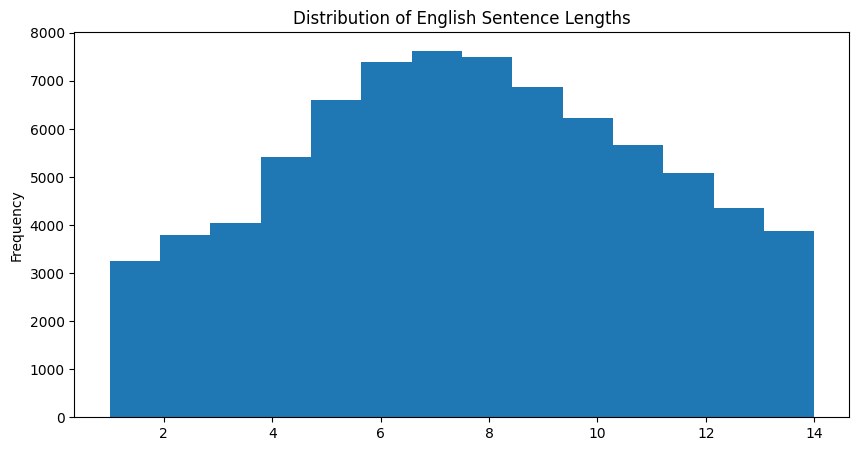

In [66]:
data['English'].str.split().apply(len).plot(kind='hist', bins=14, title='Distribution of English Sentence Lengths', figsize=(10, 5))

In [67]:
class Tokenizer:
    def __init__(self, texts):
        self.oov_token = "<|unknown|>"
        self.start_token = "<|startoftext|>"
        self.end_token = "<|endoftext|>"
        self.padding_token = "<|pad|>"
        self.word_index = {self.oov_token: 0, self.start_token: 1, self.end_token: 2, self.padding_token: 3}
    
        for text in texts:
            text = text.replace('!', '')
            text = text.replace('.', '')
            text = text.replace('(', '')
            text = text.replace(')', '')
            text = text.replace('?', '')
            text = text.replace('-', ' ')

            text = text.split()
            for word in text:
                if word not in self.word_index:
                    self.word_index[word] = len(self.word_index) + 1
        self.index_word = {idx : word for word, idx in self.word_index.items()}

        self.vocab_size = len(self.word_index)
    def encode(self, texts):
        tokenized_texts = []
        for text in texts:
            text = text.replace('!', '')
            text = text.replace('.', '')
            text = text.replace('(', '')
            text = text.replace(')', '')
            text = text.replace('?', '')
            text = text.replace('-', ' ')
            tokenized_text = []
            text = text.split()
            for word in text:
                tokenized_text.append(self.word_index.get(word, self.word_index[self.oov_token]))
            tokenized_texts.append(tokenized_text)
        return tokenized_texts
    def decode(self, sequences):
        decoded_texts = []
        for sequence in sequences:
            decoded_text = []
            for index in sequence:
                decoded_text.append(self.index_word.get(index, self.oov_token))
            decoded_texts.append(' '.join(decoded_text))
        return decoded_texts

In [68]:
eng_tokenizer = Tokenizer(data['English'])
hin_tokenizer = Tokenizer(data['Hindi'])
print(f"English Vocabulary Size: {eng_tokenizer.vocab_size}")# 80223
print(f"Hindi Vocabulary Size: {hin_tokenizer.vocab_size}")# 85059

English Vocabulary Size: 43114
Hindi Vocabulary Size: 43014


In [69]:
tokenized_text = eng_tokenizer.encode(["hello how are you raj neelam gaurav convolution", "this is a test", "what is your name"])
print(tokenized_text)
print(eng_tokenizer.decode(tokenized_text))
print()
tokenized_text = hin_tokenizer.encode(["नमस्ते आप कैसे हैं राज नीलम गौरव कन्वोल्यूशन", "यह एक परीक्षण है", "तुम्हारा नाम क्या है"])
print(tokenized_text)
print(hin_tokenizer.decode(tokenized_text))

[[7, 82, 83, 62, 8266, 26951, 0, 0], [94, 104, 110, 2144], [123, 104, 183, 306]]
['hello how are you raj neelam <|unknown|> <|unknown|>', 'this is a test', 'what is your name']

[[27205, 122, 123, 124, 3305, 28591, 5206, 0], [143, 111, 14354, 80], [404, 433, 114, 80]]
['नमस्ते आप कैसे हैं राज नीलम गौरव <|unknown|>', 'यह एक परीक्षण है', 'तुम्हारा नाम क्या है']


In [70]:
EMBED_DIM = 128
HIDDEN_DIM = 256
BATCH_SIZE = 128

START_LR = 0.005
END_LR = 0.000001
TOTAL_EPOCHS = 100

In [71]:
data, test_data = train_test_split(data, test_size=0.05)
len(data), len(test_data)

(73855, 3888)

In [72]:
# shuffle data
print(data.head())
data = data.sample(frac=1).reset_index(drop=True)
print(data.head())

                                                 English  \
45338                                  mainpuri district   
13161               in the four main pillar of chayavadi   
65223                 they talk to international donors.   
29779    whenand how , munshi got attached to premchand?   
19359  what are they most passionate about, they'd sa...   

                                                   Hindi  
45338                                       मैनपुरी जिला  
13161      छायावादी युग के चार प्रमुख स्तंभों में से एक।  
65223      वे अंतर्राष्ट्रिय दान-दाताओं से बात करते हैं.  
29779  प्रेमचंद के नाम के साथ मुंशी कब और कैसे जुड़ गया?  
19359  कि वे सबसे अधिक किसके के बारे में भावुक होते ह...  
                                             English  \
0  trees may be planted in and around the factory...   
1  the old man sat in the chair with his eyes clo...   
2                 throwing the bomb on the assembly.   
3  here you get tarai region as well as cold hima...   
4    

In [73]:
class MyDataset(Dataset):
    def __init__(self, data, eng_tokenizer, hin_tokenizer):
        self.data = data
        self.eng_tokenizer = eng_tokenizer
        self.hin_tokenizer = hin_tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        eng_text = self.data.iloc[idx]['English']
        hin_text = self.data.iloc[idx]['Hindi']

        eng_tokenized = self.eng_tokenizer.encode([eng_text])[0]
        if len(eng_tokenized) > MAX_SENT_LEN:
            eng_tokenized = eng_tokenized[:MAX_SENT_LEN]

        eng_padded = [self.eng_tokenizer.word_index[self.eng_tokenizer.padding_token]] * (MAX_SENT_LEN - len(eng_tokenized)) + eng_tokenized

        hin_tokenized = self.hin_tokenizer.encode([hin_text])[0]

        if len(hin_tokenized) > MAX_SENT_LEN - 2:
            hin_tokenized = hin_tokenized[:MAX_SENT_LEN - 2]
        hin_padded = [self.hin_tokenizer.word_index[self.hin_tokenizer.start_token]] + hin_tokenized + [self.hin_tokenizer.word_index[self.hin_tokenizer.end_token]] + [self.hin_tokenizer.word_index[self.hin_tokenizer.padding_token]] * (MAX_SENT_LEN - len(hin_tokenized) - 2)

        return {
            'eng_input': torch.tensor(eng_padded),
            'hin_target': torch.tensor(hin_padded)
        }

dataset = DataLoader(MyDataset(data, eng_tokenizer, hin_tokenizer), batch_size=BATCH_SIZE, shuffle=True)
test_dataset = DataLoader(MyDataset(test_data, eng_tokenizer, hin_tokenizer), batch_size=BATCH_SIZE, shuffle=True)

In [74]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, EMBED_DIM)
        self.rnn = nn.LSTM(EMBED_DIM, hidden_dim, num_layers, batch_first=True)

    def forward(self, src):
        outputs, (h, c) = self.rnn(self.embedding(src))
        return outputs, (h, c)

In [75]:
import torch.nn.functional as F

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W1 = nn.Linear(hidden_dim, hidden_dim)
        self.W2 = nn.Linear(hidden_dim, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)

    def forward(self, hidden, encoder_outputs):
        # In LSTM, 'hidden' passed from decoder is (h, c). We use h.
        h, c = hidden 
        # last_hidden: (B, 1, H)
        last_h = h[-1].unsqueeze(1) 
        
        # encoder_outputs: (B, T, H)
        # self.W1(encoder_outputs) -> (B, T, H)
        # self.W2(last_h) -> (B, 1, H)
        score = self.V(torch.tanh(self.W1(encoder_outputs) + self.W2(last_h))) # (B, T, 1)
        
        attention_weights = F.softmax(score, dim=1).transpose(1, 2) # (B, 1, T)
        context_vector = torch.bmm(attention_weights, encoder_outputs) # (B, 1, H)
        
        return context_vector, attention_weights

In [76]:
class Decoder(nn.Module):
    def __init__(self, output_dim, embed_dim, hidden_dim, num_layers=2):
        super().__init__()
        self.attention = BahdanauAttention(hidden_dim)
        self.embedding = nn.Embedding(output_dim, embed_dim)
        
        # RNN input is embedding + context
        self.rnn = nn.LSTM(embed_dim + hidden_dim, hidden_dim, num_layers, batch_first=True)
        
        # FIX: FC input is RNN output (hidden_dim) + context (hidden_dim)
        self.fc = nn.Linear(hidden_dim + hidden_dim, output_dim)

    def forward(self, input_token, hidden, encoder_outputs):
        input_token = input_token.unsqueeze(1) 
        embedded = self.embedding(input_token) 

        # 1. Get attention context
        context, weights = self.attention(hidden, encoder_outputs)

        # 2. Concat embedding and context for RNN input
        rnn_input = torch.cat((embedded, context), dim=2)
        output, (h, c) = self.rnn(rnn_input, hidden)

        # 3. Concat RNN output and Context for the prediction
        # output: (B, 1, H) -> squeeze(1) -> (B, H)
        # context: (B, 1, H) -> squeeze(1) -> (B, H)
        combined = torch.cat((output.squeeze(1), context.squeeze(1)), dim=1)
        
        prediction = self.fc(combined)

        return prediction, (h, c), weights

In [77]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        trg_len = trg.size(1)
        vocab_size = self.decoder.fc.out_features

        outputs = torch.zeros(batch_size, trg_len, vocab_size).to(self.device)
        
        # Get all encoder hidden states
        encoder_outputs, hidden = self.encoder(src)

        input_token = trg[:, 0] # <start> token

        for t in range(1, trg_len):
            output, hidden, _ = self.decoder(input_token, hidden, encoder_outputs)
            outputs[:, t] = output
            
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_token = trg[:, t] if teacher_force else top1

        return outputs

In [78]:
encoder = Encoder(input_dim=eng_tokenizer.vocab_size+1, hidden_dim=HIDDEN_DIM)
decoder = Decoder(output_dim=hin_tokenizer.vocab_size+1, embed_dim=EMBED_DIM, hidden_dim=HIDDEN_DIM)

model = Seq2Seq(encoder, decoder, device).to(device)


In [79]:
# data_iter = iter(dataset)
# sample_batch = next(data_iter)
# X_sample = sample_batch['eng_input'].to(device)
# y_sample = sample_batch['hin_target'].to(device)
# writer.add_graph(model, [X_sample, y_sample])

In [80]:
# # load saved weights and set model to evaluation mode
# checkpoint_path = "models/Bahdanau_attention_LSTM_model_epoch_10.pth"
# state_dict = torch.load(checkpoint_path, map_location=device)
# model.load_state_dict(state_dict)
# model.to(device)
# model.train()

In [81]:
crition = nn.CrossEntropyLoss(ignore_index=hin_tokenizer.word_index[hin_tokenizer.padding_token])
optimizer = torch.optim.Adam(model.parameters(), lr=START_LR) 

In [82]:
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    # print(f"Model saved to {filepath}")
torch.cuda.empty_cache()

In [83]:
def get_linear_lr(epoch, total_epochs, start_lr, end_lr):
    """
    Calculates a linearly interpolated learning rate.
    """
    if epoch >= total_epochs:
        return end_lr
    
    # Formula: start + (end - start) * (progress)
    lr = start_lr + (end_lr - start_lr) * (epoch / total_epochs)
    return lr

In [84]:
for epoch in range(0, TOTAL_EPOCHS):
    
    current_lr = get_linear_lr(epoch, TOTAL_EPOCHS, START_LR, END_LR)
    for param_group in optimizer.param_groups:
        param_group['lr'] = current_lr
    
    tqdm_bar = tqdm(dataset)

    for i, batch in enumerate(tqdm_bar):
        model.train()
        # load batch to device
        X, y = batch['eng_input'].to(device), batch['hin_target'].to(device)

        # forward pass
        logits = model(X, y)
        loss = crition(logits.view(-1, logits.size(-1)), y.view(-1))    
        writer.add_scalar('Training Loss', loss.item(), epoch * len(tqdm_bar) + i)
        writer.add_scalar('Learning Rate', optimizer.param_groups[0]['lr'], epoch * len(tqdm_bar) + i)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # gradient clipping
        optimizer.step()

        tqdm_bar.set_description(f"Epoch: {epoch+1}")

        if i % 100 == 0:
            for name, param in model.named_parameters():
                if param.requires_grad:
                    writer.add_histogram(f'Weights/{name}', param, global_step=i)
                    # Logging gradients is also super helpful!
                    if param.grad is not None:
                        writer.add_histogram(f'Gradients/{name}', param.grad, global_step=i)
    
    k=0
    sumer=0
    for d in test_dataset:

        model.eval()
        tX, ty = d['eng_input'].to(device), d['hin_target'].to(device)
        # test loss
        test_logits = model(tX, ty)
        test_loss = crition(test_logits.view(-1, test_logits.size(-1)), ty.view(-1))
        # lat = 'UND' if len(losses_test)<50 else f"{(sum(losses_test[-50:])/50):.4f}"
        sumer+=test_loss.item()
        k+=1
    print("Average Test Loss: ",sumer/(k+0.00001))
    writer.add_scalar('Test Loss', sumer/(k+0.00001), epoch)
    
    save_model(model, f"models/Bahdanau_LSTM_attention_model_epoch_{epoch+1}.pth")
    

Epoch: 1: 100%|██████████| 577/577 [03:55<00:00,  2.45it/s]


Average Test Loss:  6.805753266011657


Epoch: 2: 100%|██████████| 577/577 [04:15<00:00,  2.26it/s]


Average Test Loss:  6.544504684814163


Epoch: 3: 100%|██████████| 577/577 [04:16<00:00,  2.25it/s]


Average Test Loss:  6.358663861200173


Epoch: 4: 100%|██████████| 577/577 [04:15<00:00,  2.26it/s]


Average Test Loss:  6.299678000883546


Epoch: 5: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s]


Average Test Loss:  6.1670665382145415


Epoch: 6: 100%|██████████| 577/577 [04:13<00:00,  2.28it/s]


Average Test Loss:  6.186351810929072


Epoch: 7: 100%|██████████| 577/577 [04:13<00:00,  2.28it/s]


Average Test Loss:  6.163301064063787


Epoch: 8: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s]


Average Test Loss:  6.1784734176515945


Epoch: 9: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  6.293090343849582


Epoch: 10: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s]


Average Test Loss:  6.322848295400381


Epoch: 11: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  6.362030345832969


Epoch: 12: 100%|██████████| 577/577 [04:11<00:00,  2.30it/s]


Average Test Loss:  6.443827688511552


Epoch: 13: 100%|██████████| 577/577 [04:11<00:00,  2.30it/s]


Average Test Loss:  6.526146921600516


Epoch: 14: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s]


Average Test Loss:  6.631433301260608


Epoch: 15: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  6.615867187980052


Epoch: 16: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  6.702305831331733


Epoch: 17: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s]


Average Test Loss:  6.901521425318032


Epoch: 18: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s]


Average Test Loss:  6.9270094399311155


Epoch: 19: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  6.987186239120792


Epoch: 20: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  7.135446846236471


Epoch: 21: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  7.24937706562079


Epoch: 22: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s]


Average Test Loss:  7.26288745766625


Epoch: 23: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  7.374317866746001


Epoch: 24: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  7.381279410136918


Epoch: 25: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  7.565211362931322


Epoch: 26: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  7.581275186371585


Epoch: 27: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s]


Average Test Loss:  7.5765134151366045


Epoch: 28: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s]


Average Test Loss:  7.8050348730480295


Epoch: 29: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  7.840548662551401


Epoch: 30: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  7.950505614523926


Epoch: 31: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  8.156815635606977


Epoch: 32: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  8.056996176820316


Epoch: 33: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s]


Average Test Loss:  8.158778712026674


Epoch: 34: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  8.316944192779273


Epoch: 35: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  8.336610181387208


Epoch: 36: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  8.297553600614128


Epoch: 37: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  8.389669849885985


Epoch: 38: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  8.550694737571813


Epoch: 39: 100%|██████████| 577/577 [04:11<00:00,  2.30it/s]


Average Test Loss:  8.628918694503215


Epoch: 40: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  8.621308360531396


Epoch: 41: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  8.68491667876853


Epoch: 42: 100%|██████████| 577/577 [04:11<00:00,  2.30it/s]


Average Test Loss:  8.818471401941402


Epoch: 43: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s]


Average Test Loss:  8.945576120156188


Epoch: 44: 100%|██████████| 577/577 [04:11<00:00,  2.30it/s]


Average Test Loss:  8.921751897524274


Epoch: 45: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s]


Average Test Loss:  8.969391821249378


Epoch: 46: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  9.151792096676504


Epoch: 47: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s]


Average Test Loss:  9.18425031465578


Epoch: 48: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  9.264517871933263


Epoch: 49: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  9.36128920400583


Epoch: 50: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s]


Average Test Loss:  9.453268508766396


Epoch: 51: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s]


Average Test Loss:  9.556937918762781


Epoch: 52: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s]


Average Test Loss:  9.845924800688085


Epoch: 53: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s]


Average Test Loss:  9.820747714565536


Epoch: 54: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s]


Average Test Loss:  9.754602238919105


Epoch: 55: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  9.811866856086453


Epoch: 56: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  9.78503585312328


Epoch: 57: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s]


Average Test Loss:  10.008408609643423


Epoch: 58: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  10.043756290669043


Epoch: 59: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s]


Average Test Loss:  10.156633177110676


Epoch: 60: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s]


Average Test Loss:  10.218467246381849


Epoch: 61: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s]


Average Test Loss:  10.25837798066633


Epoch: 62: 100%|██████████| 577/577 [04:11<00:00,  2.30it/s]


Average Test Loss:  10.523182181587133


Epoch: 63: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  10.668625035789193


Epoch: 64: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  10.458758087526531


Epoch: 65: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s]


Average Test Loss:  10.531304469301434


Epoch: 66: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  10.651830713440052


Epoch: 67: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  10.854149547269047


Epoch: 68: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  10.917989592908473


Epoch: 69: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  10.703316281460001


Epoch: 70: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s]


Average Test Loss:  10.981294412083235


Epoch: 71: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  10.878525701042618


Epoch: 72: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  10.998351579294665


Epoch: 73: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s]


Average Test Loss:  11.228161204682515


Epoch: 74: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  11.254990454116061


Epoch: 75: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  11.27044769474123


Epoch: 76: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  11.327430701202893


Epoch: 77: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s]


Average Test Loss:  11.352244160655


Epoch: 78: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  11.503395492127808


Epoch: 79: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s]


Average Test Loss:  11.480977231094244


Epoch: 80: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s]


Average Test Loss:  11.577993103640866


Epoch: 81: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s]


Average Test Loss:  11.453831515708174


Epoch: 82: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s]


Average Test Loss:  11.6885162611015


Epoch: 83: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  11.593196882325445


Epoch: 84: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  11.637620371255746


Epoch: 85: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  11.582730956116432


Epoch: 86: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s]


Average Test Loss:  11.714757678181511


Epoch: 87: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s]


Average Test Loss:  11.923022515636795


Epoch: 88: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  11.836613713052484


Epoch: 89: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s]


Average Test Loss:  11.849688799058459


Epoch: 90: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  12.012850331833578


Epoch: 91: 100%|██████████| 577/577 [04:11<00:00,  2.29it/s]


Average Test Loss:  11.955178741973906


Epoch: 92: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  11.85192559530051


Epoch: 93: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s]


Average Test Loss:  12.073943704036715


Epoch: 94: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  12.061756519296583


Epoch: 95: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  11.86588424489377


Epoch: 96: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  12.252350423406602


Epoch: 97: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  12.18097844502798


Epoch: 98: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  12.034996765010966


Epoch: 99: 100%|██████████| 577/577 [04:12<00:00,  2.29it/s]


Average Test Loss:  12.091381448704999


Epoch: 100: 100%|██████████| 577/577 [04:12<00:00,  2.28it/s]


Average Test Loss:  12.215199775521887


In [88]:
writer.close()
# plt.plot(average_losses)

In [90]:
def translate_sentence_with_attention(model, sentence, eng_tokenizer, hin_tokenizer, device, max_len=MAX_SENT_LEN):
    model.eval()
    
    # 1. Preprocess
    sentence = sentence.lower().replace('!', '').replace('.', '').replace('?', '')
    tokens = eng_tokenizer.encode([sentence])[0]
    padding_idx = eng_tokenizer.word_index[eng_tokenizer.padding_token]
    padded_tokens = [padding_idx] * (max_len - len(tokens)) + tokens
    src_tensor = torch.LongTensor(padded_tokens).unsqueeze(0).to(device)

    with torch.no_grad():
        # 2. Get BOTH encoder outputs and hidden state
        encoder_outputs, hidden = model.encoder(src_tensor)

        start_idx = hin_tokenizer.word_index[hin_tokenizer.start_token]
        end_idx = hin_tokenizer.word_index[hin_tokenizer.end_token]
        
        input_token = torch.LongTensor([start_idx]).to(device)
        translated_indices = []

        # 3. Step through decoder
        for _ in range(max_len):
            # Attention Decoder now requires encoder_outputs!
            output, hidden, _ = model.decoder(input_token, hidden, encoder_outputs)
            
            top1 = output.argmax(1)
            idx = top1.item()
            
            if idx == end_idx:
                break
                
            translated_indices.append(idx)
            input_token = top1 

    return hin_tokenizer.decode([translated_indices])[0]

In [91]:
translate_sentence_with_attention(
    model, "hello my friend how are you", eng_tokenizer, hin_tokenizer, device)

'मेरे लिए मेरी समय लग रहा हो।'